# 환경 설정

In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
# 라이브러리 설정
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터셋 불러오기

In [3]:
# 데이콘 사이트에서 다운로드한 CSV파일을 읽어오기
drive_path = "/gdrive/My Drive/"

train = pd.read_csv(drive_path + "titanic/train.csv")
test = pd.read_csv(drive_path + "titanic/test.csv")
submission = pd.read_csv(drive_path + "titanic/sample_submission.csv")

print(train.shape, test.shape, submission.shape)

(891, 12) (418, 11) (418, 2)


In [4]:
# train 데이터프레임 내용 확인
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
# test 데이터프레임 내용 확인
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [6]:
# submission 제출파일 양식 확인
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# 데이터 살펴보기

### 데이터 구조

In [7]:
# train 데이터프레임 개요 정보
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
# train 데이터프레임 통계정보
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Penasco y Castellana, Mrs. Victor de Satode (M...",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


### 결측값 확인

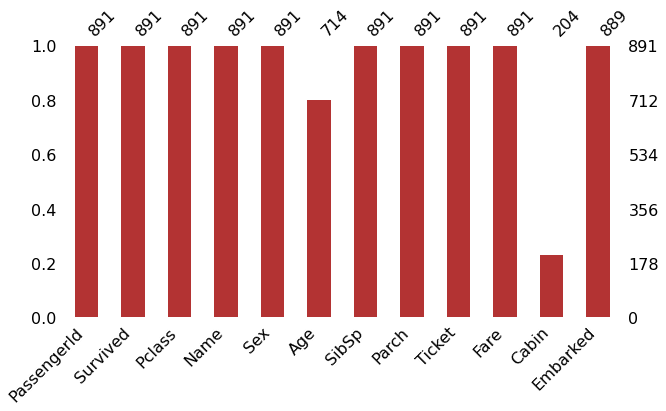

In [9]:
# 결측값 분포
import missingno as msno
msno.bar(train, figsize=(10, 5), color=(0.7, 0.2, 0.2))
plt.show()

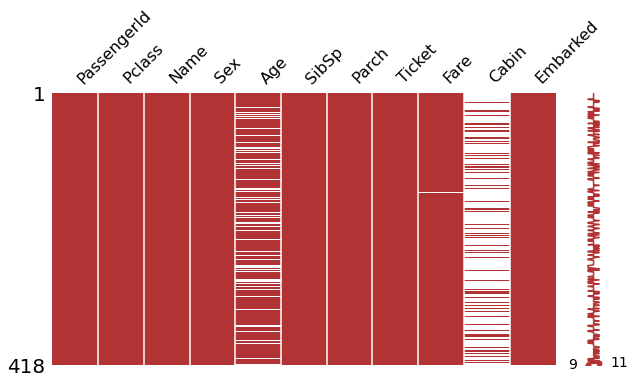

In [10]:
msno.matrix(test, figsize=(10, 5), color=(0.7, 0.2, 0.2))
plt.show()

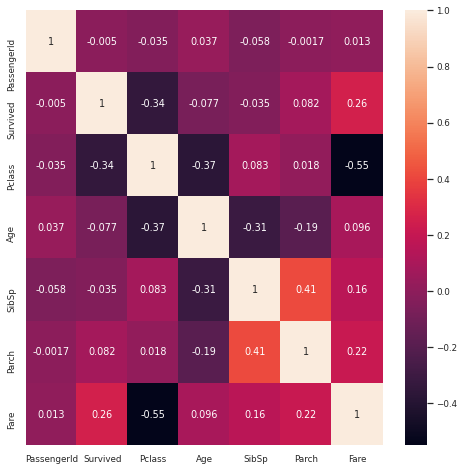

In [11]:
# 숫자형 변수 간의 상관관계를 계산하여 히트맵 그리기
plt.figure(figsize=(8, 8))
sns.set(font_scale=0.8)
sns.heatmap(train.corr(), annot=True, cbar=True);
plt.show()

### 데이터셋 결합 

In [12]:
# 타이타닉 전체 데이터셋 준비
train['TrainSplit'] = 'Train'
test['TrainSplit'] = 'Test'
data = pd.concat([train, test], axis=0)
print(data.shape)

(1309, 13)


# 베이스라인 모델 학습
- 숫자형 데이터만 사용

### 데이터 전처리

In [13]:
# 숫자형 피처 추출
data_num = data.loc[:, ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']]

# 결측값 대체
data_num['Age'] = data_num['Age'].fillna(data_num['Age'].mean())
data_num['Fare'] = data_num['Fare'].fillna(data_num['Fare'].mode()[0])

# 학습용 데이터와 예측 대상인 테스트 데이터 구분
selected_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

X_train = data_num.loc[data['TrainSplit']=='Train', selected_features] 
y_train = data_num.loc[data['TrainSplit']=='Train', 'Survived']

X_test = data_num.loc[data['TrainSplit']=='Test', selected_features]

print("Train 데이터셋 크기: ", X_train.shape, y_train.shape)
print("Test 데이터셋 크기: ", X_test.shape)

Train 데이터셋 크기:  (891, 5) (891,)
Test 데이터셋 크기:  (418, 5)


### 교차 검증 

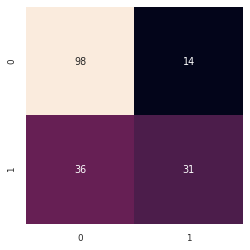

In [14]:
# 훈련 - 검증 데이터 분할
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val =  train_test_split(X_train, y_train, test_size=0.2, 
                                             shuffle=True, random_state=20)

# 로지스틱 회귀 모델
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(X_tr, y_tr)
y_val_pred = lr_model.predict(X_val)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, cbar=False, square=True)
plt.show()

In [15]:
# 평가 지표
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score 
print("Accuracy: %.4f" % accuracy_score(y_val, y_val_pred))
print("Precision: %.4f" % precision_score(y_val, y_val_pred))
print("Recall: %.4f" % recall_score(y_val, y_val_pred))
print("F1: %.4f" % f1_score(y_val, y_val_pred))
print("AUC: %.4f" % roc_auc_score(y_val, y_val_pred))

Accuracy: 0.7207
Precision: 0.6889
Recall: 0.4627
F1: 0.5536
AUC: 0.6688


### 제출 파일 만들기

In [16]:
# test 데이터에 대한 예측값 정리
y_test_pred = lr_model.predict(X_test)

# 제출양식에 맞게 정리
submission['Survived'] = y_test_pred.astype(int)

# 제출파일 저장 
submission_filepath = drive_path + 'baseline_num_lr_submission_001.csv'    
submission.to_csv(submission_filepath, index=False)
submission.head(5)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


# 피처 엔지니어링
- 문자열, 범주형 변수를 포함
- 데이터 탐색(EDA) 및 전처리(pre-processing) 포함

### Survived : 생존 여부

In [17]:
# 타겟 레이블의 분포 확인
train['Survived'].value_counts(dropna=False)

0    549
1    342
Name: Survived, dtype: int64

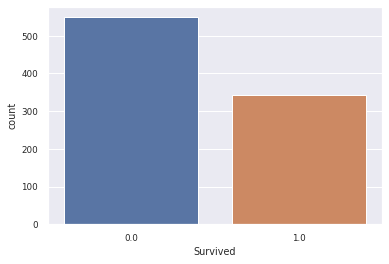

In [18]:
# 객실 등급별 분포 확인
sns.countplot(x='Survived', data=data[data['TrainSplit']=='Train'])
plt.show()

### Pclass : 객실 등급

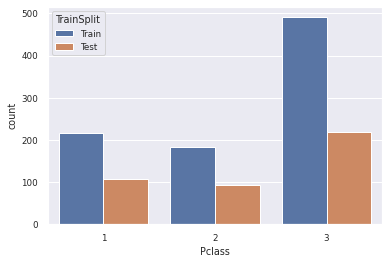

In [ ]:
# train - test 데이터 분포
sns.countplot(x='Pclass', hue='TrainSplit', data=data)
plt.show()

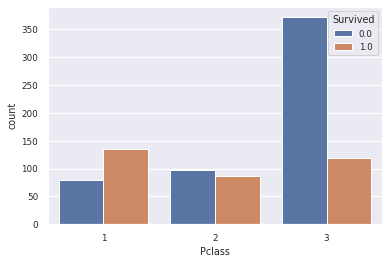

In [ ]:
# Pclass별 Survived 여부
sns.countplot(x='Pclass', hue='Survived', data=data[data['TrainSplit']=='Train'])
plt.show()

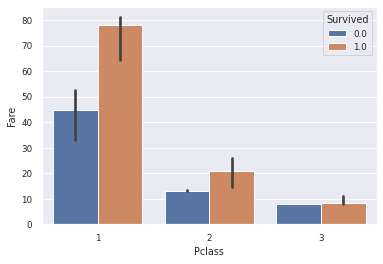

In [ ]:
# Pclass별 Fare 객실요금의 중간값 비교
sns.barplot(x='Pclass', y='Fare', hue='Survived', 
            data=data[data['TrainSplit']=='Train'], estimator=np.median)
plt.show()

### Sex : 성별

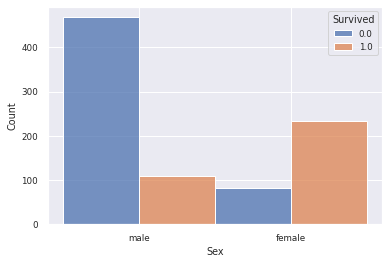

In [ ]:
# histplot 함수 - dodge 옵션
sns.histplot(x='Sex', hue='Survived', multiple='dodge', 
             data=data[data['TrainSplit']=='Train'])
plt.show()

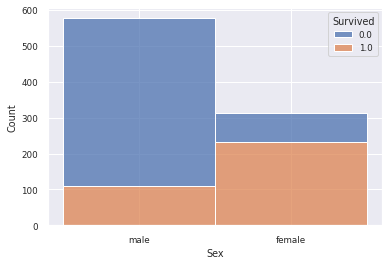

In [ ]:
# histplot 함수 - stack 옵션
sns.histplot(x='Sex', hue='Survived', multiple='stack', 
             data=data[data['TrainSplit']=='Train'])
plt.show()

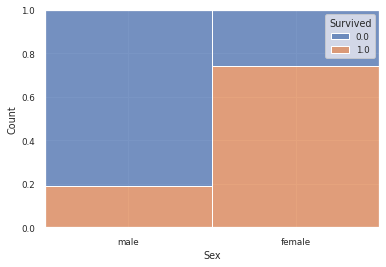

In [ ]:
# histplot 함수 - fill 옵션
sns.histplot(x='Sex', hue='Survived', multiple='fill', 
             data=data[data['TrainSplit']=='Train'])
plt.show()

In [ ]:
# 레이블 인코딩 (female: 0, male: 1)
data.loc[data['Sex']=='female', 'Sex'] = 0
data.loc[data['Sex']=='male', 'Sex'] = 1
data['Sex'] = data['Sex'].astype(int)

# 성별 분포 확인
data['Sex'].value_counts(dropna=False)

1    843
0    466
Name: Sex, dtype: int64

### Name : 이름
- 문자열 피처 다루기 : Name(이름)에서 Mr. Dona 등 title 정보를 추출 (신분을 나타내는 정보)

In [ ]:
data['Name'].unique()

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina', ..., 'Saether, Mr. Simon Sivertsen',
       'Ware, Mr. Frederick', 'Peter, Master. Michael J'], dtype=object)

In [ ]:
title_name = data['Name'].str.split(", ", expand=True)[1]
title_name

0                                 Mr. Owen Harris
1      Mrs. John Bradley (Florence Briggs Thayer)
2                                     Miss. Laina
3              Mrs. Jacques Heath (Lily May Peel)
4                               Mr. William Henry
                          ...                    
413                                     Mr. Woolf
414                                 Dona. Fermina
415                           Mr. Simon Sivertsen
416                                 Mr. Frederick
417                             Master. Michael J
Name: 1, Length: 1309, dtype: object

In [ ]:
title = title_name.str.split(".", expand=True)[0]
title.value_counts(dropna=False)

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Mlle              2
Ms                2
Mme               1
Lady              1
Jonkheer          1
Don               1
the Countess      1
Capt              1
Dona              1
Sir               1
Name: 0, dtype: int64

In [ ]:
title = title.replace(['Ms'], 'Miss')
title = title.replace(['Mlle', 'the Countess', 'Lady', 'Don', 'Dona', 'Mme', 'Sir', 'Jonkheer'], 'Noble')
title = title.replace(['Col', 'Major', 'Capt'], 'Officer')
title = title.replace(['Dr', 'Rev'], 'Priest')
data['Title'] = np.array(title)
data['Title'].value_counts(dropna=False)

Mr         757
Miss       262
Mrs        197
Master      61
Priest      16
Noble        9
Officer      7
Name: Title, dtype: int64

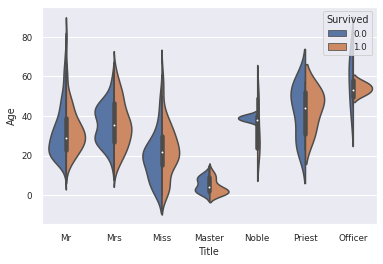

In [ ]:
# 승객 나이와 생존 여부와의 관계
sns.violinplot(x='Title', y='Age', hue='Survived', data=data,  split=True)
plt.show()

In [ ]:
# Name 열 삭제
data = data.drop('Name', axis=1)
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'TrainSplit', 'Title'],
      dtype='object')

### Age : 나이

In [ ]:
#결측값 확인 및 대체
for title in data['Title'].unique():
    # 결측값 개수 확인
    print("%s 결측값 개수: " % title, data.loc[data['Title']==title, 'Age'].isnull().sum())  
    # 각 Title의 중앙값으로 대체  
    age_med = data.loc[data['Title']==title, 'Age'].median()
    data.loc[data['Title']==title, 'Age'] = data.loc[data['Title']==title, 'Age'].fillna(age_med)

# 결측값 처리 여부 확인
print("\n")
print("Age 열의 결측값 개수: ", data['Age'].isnull().sum())

Mr 결측값 개수:  176
Mrs 결측값 개수:  27
Miss 결측값 개수:  51
Master 결측값 개수:  8
Noble 결측값 개수:  0
Priest 결측값 개수:  1
Officer 결측값 개수:  0


Age 열의 결측값 개수:  0


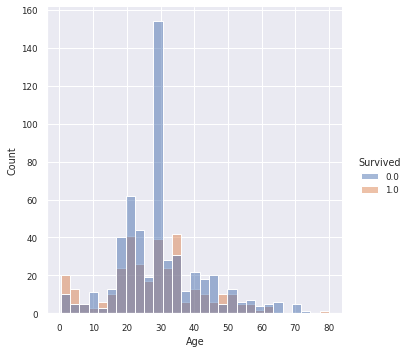

In [ ]:
# Age 분포
sns.displot(x='Age', kind='hist', hue='Survived', 
            data=data[data['TrainSplit']=='Train'])
plt.show()

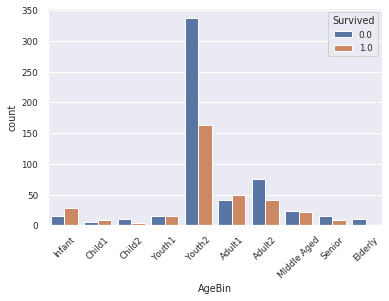

In [ ]:
# Binning - 구간 나누기
bins = [0, 4, 8, 12, 16, 32, 36, 48, 56, 64, 100]
labels = ['Infant', 'Child1', 'Child2', 'Youth1', 'Youth2', 'Adult1', 'Adult2','MIddle Aged', 'Senior', 'Elderly']
data['AgeBin'] = pd.cut(data['Age'], bins=bins, labels=labels)

# Age_bin (나이 구간)에 따른 생존율 비교
sns.countplot(x = 'AgeBin', hue = 'Survived', 
              data=data[data['TrainSplit']=='Train'])
plt.xticks(rotation=45)
plt.show()

### SibSp: 형제자매/배우자

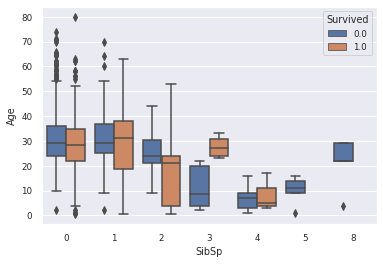

In [ ]:
# 형제자매/배우자 수와 승객 나이 및 생존율 관계
sns.boxplot(x='SibSp', y='Age', hue='Survived', 
            data=data[data['TrainSplit']=='Train'])
plt.show()

### Parch:부모자식

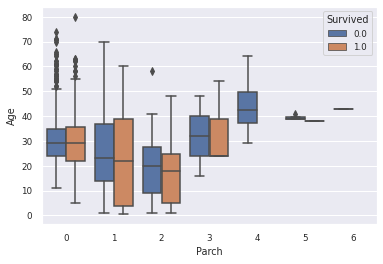

In [ ]:
# 부모자식 수에 따른 승객 나이 및 생존율 관계
sns.boxplot(x='Parch', y='Age', hue='Survived', 
            data=data[data['TrainSplit']=='Train'])
plt.show()

* 피처 교합 (feature interaction)

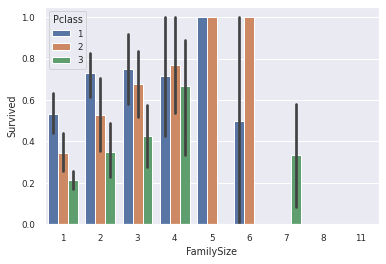

In [ ]:
# 가족 구성원의 수
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

# 가족 구성원의 수와 생존율 관계
sns.barplot(x='FamilySize', y='Survived', hue='Pclass', estimator=np.mean,
            data=data[data['TrainSplit']=='Train'])
plt.show()

### Fare : 요금

In [ ]:
# 결측값 확인
data.loc[data['Fare'].isnull(), :]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TrainSplit,Title,AgeBin,FamilySize
152,1044,NaN,3,1,60.5,0,0,3701,NaN,NaN,S,Test,Mr,Senior,1


In [ ]:
# 3등석 요금의 평균값을 가지고 결측값 대체
p3_fare_mean = data.loc[data['Pclass']==3, 'Fare'].mean()
print(p3_fare_mean)
data['Fare']= data['Fare'].fillna(p3_fare_mean)
data.loc[data['PassengerId']==1044, :'Fare']

13.302888700564969


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare
152,1044,NaN,3,1,60.5,0,0,3701,13.302889


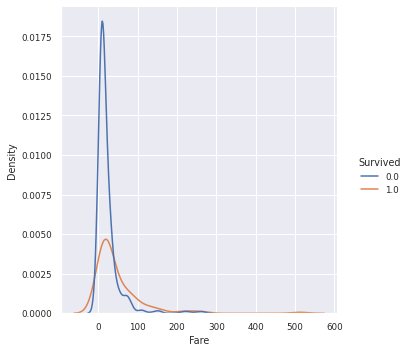

In [ ]:
# Fare 분포
sns.displot(x='Fare', kind='kde', hue='Survived', 
            data=data[data['TrainSplit']=='Train'])
plt.show()

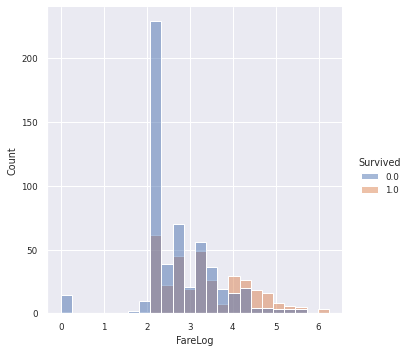

In [ ]:
# log 변환
data['FareLog'] = np.log1p(data['Fare'])

# FareLog 분포
sns.displot(x='FareLog', kind='hist', hue='Survived', 
            data=data[data['TrainSplit']=='Train'])
plt.show()

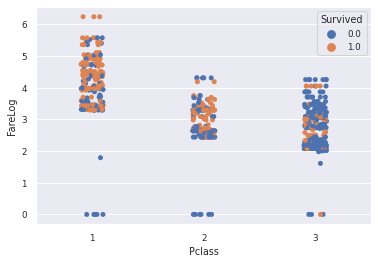

In [ ]:
# 객실 등급 별 객실 요금 분포와 생존율
sns.stripplot(x='Pclass', y='FareLog', hue='Survived', 
              data=data[data['TrainSplit']=='Train'])
plt.show()

### Embarked : 탑승 항구

In [ ]:
# 결측값 확인
data.loc[data['Embarked'].isnull(), :]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TrainSplit,Title,AgeBin,FamilySize,FareLog
61,62,1.0,1,0,38.0,0,0,113572,80.0,B28,NaN,Train,Miss,Adult2,1,4.394449
829,830,1.0,1,0,62.0,0,0,113572,80.0,B28,NaN,Train,Mrs,Senior,1,4.394449


In [ ]:
# 최빈값을 사용하여 결측값 처리
print("Embarked 열의 최빈값:", data['Embarked'].mode()[0])
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
data['Embarked'].value_counts(dropna=False)

Embarked 열의 최빈값: S


S    916
C    270
Q    123
Name: Embarked, dtype: int64

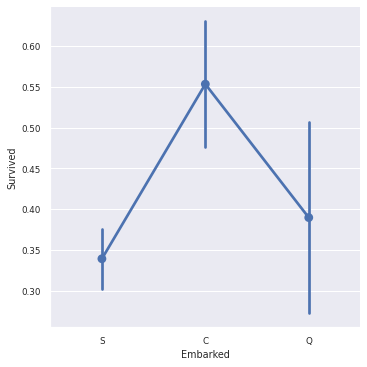

In [ ]:
# 탑승 항구별 생존율 비교
sns.catplot(x='Embarked',  y='Survived', kind='point',
               data=data[data['TrainSplit']=='Train'])
plt.show()

### Cabin : 객실 구역

In [ ]:
# 고유값 확인
data['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [ ]:
# 첫번째 알파벳 이니셜 추출
data['Cabin'].str.slice(0, 1).value_counts(dropna=False)

NaN    1014
C        94
B        65
D        46
E        41
A        22
F        21
G         5
T         1
Name: Cabin, dtype: int64

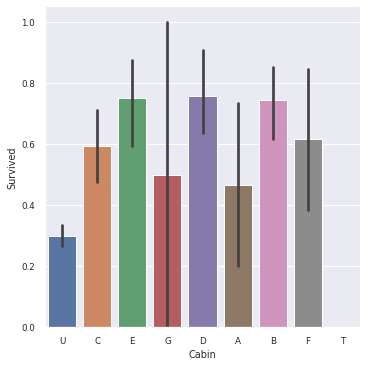

In [ ]:
# 알파벳 이니셜로 대체, 결측값은 'U'로 입력
data['Cabin'] = data['Cabin'].str.slice(0, 1)
data['Cabin'] = data['Cabin'].fillna('U')

# Cabin 구역별 생존율 비교
sns.catplot(x='Cabin',  y='Survived', kind='bar',
               data=data[data['TrainSplit']=='Train'])
plt.show()

### Ticket : 티켓 정보

In [ ]:
# 고유값 확인
data['Ticket'].value_counts(dropna=False)

CA. 2343    11
1601         8
CA 2144      8
PC 17608     7
3101295      7
            ..
349202       1
17765        1
349240       1
350025       1
347078       1
Name: Ticket, Length: 929, dtype: int64

In [ ]:
# 문자열 정리 - 알파벳 추출
data['Ticket'] = data['Ticket'].str.replace(".","").str.replace("/","")
data['Ticket'] = data['Ticket'].str.strip().str.split(' ').str[0]
data['Ticket'].value_counts(dropna=False)

PC         92
CA         68
A5         28
SOTONOQ    24
WC         15
           ..
239059      1
347067      1
13568       1
349229      1
17770       1
Name: Ticket, Length: 741, dtype: int64

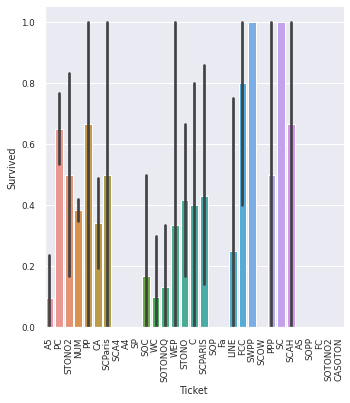

In [ ]:
# 문자열이 숫자인 경우에는 "NUM"으로 대체
data.loc[data['Ticket'].str.isdigit(), 'Ticket'] = 'NUM'
data['Ticket'].value_counts(dropna=False)[:10]

# Ticket 번호별 생존율 비교
sns.catplot(x='Ticket',  y='Survived', kind='bar',
               data=data[data['TrainSplit']=='Train'])
plt.xticks(rotation=90)
plt.show()

# 데이터 전처리

### 레이블 인코딩

In [ ]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
for col in ['Title', 'AgeBin']:
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col])

data.loc[:, ['Title', 'AgeBin']].head()

,Title,AgeBin
0,2,9
1,3,1
2,1,9
3,3,0
4,2,0


### 원핫인코딩

In [ ]:
# 범주형 변수로 변환 및 원핫인코딩
onehot_prefix = []
for col in ['Embarked', 'Cabin', 'Ticket']:
    data[col] = data[col].astype('category')
    data = pd.get_dummies(data, columns = [col], prefix=col[:3], drop_first=True)
    onehot_prefix.append(col[:3])

data.loc[:,[col for col in data.columns if col[:3] in onehot_prefix]].head()

,Emb_Q,Emb_S,Cab_B,Cab_C,Cab_D,Cab_E,Cab_F,Cab_G,Cab_T,Cab_U,Tic_A4,Tic_A5,Tic_AQ3,Tic_AQ4,Tic_AS,Tic_C,Tic_CA,Tic_CASOTON,Tic_FC,Tic_FCC,Tic_Fa,Tic_LINE,Tic_LP,Tic_NUM,Tic_PC,Tic_PP,Tic_PPP,Tic_SC,Tic_SCA3,Tic_SCA4,Tic_SCAH,Tic_SCOW,Tic_SCPARIS,Tic_SCParis,Tic_SOC,Tic_SOP,Tic_SOPP,Tic_SOTONO2,Tic_SOTONOQ,Tic_SP,Tic_STONO,Tic_STONO2,Tic_STONOQ,Tic_SWPP,Tic_WC,Tic_WEP
0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 피처 스케일링

In [ ]:
# 피처 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

# 스케일링 처리할 피처 선택 - TrainSplit 등 일부 열을 제외
scaled_cols = [col for col in data.loc[:, 'Pclass':].columns if col!='TrainSplit']

data_scaled = data.loc[:, scaled_cols]
data_scaled = scaler.fit_transform(data_scaled)

# 스케일링 변환된 값을 데이터프레임에 반영
data.loc[:, scaled_cols] = data_scaled[:, :]
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,TrainSplit,Title,AgeBin,FamilySize,FareLog,Emb_Q,Emb_S,Cab_B,Cab_C,Cab_D,Cab_E,Cab_F,Cab_G,Cab_T,Cab_U,Tic_A4,Tic_A5,Tic_AQ3,Tic_AQ4,Tic_AS,Tic_C,Tic_CA,Tic_CASOTON,Tic_FC,Tic_FCC,Tic_Fa,Tic_LINE,Tic_LP,Tic_NUM,Tic_PC,Tic_PP,Tic_PPP,Tic_SC,Tic_SCA3,Tic_SCA4,Tic_SCAH,Tic_SCOW,Tic_SCPARIS,Tic_SCParis,Tic_SOC,Tic_SOP,Tic_SOPP,Tic_SOTONO2,Tic_SOTONOQ,Tic_SP,Tic_STONO,Tic_STONO2,Tic_STONOQ,Tic_SWPP,Tic_WC,Tic_WEP
0,1,0.0,1.0,1.0,0.273456,0.125,0.0,0.014151,Train,0.333333,1.000000,0.1,0.338125,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,0.0,0.0,0.473882,0.125,0.0,0.139136,Train,0.500000,0.111111,0.1,0.685892,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,1.0,0.0,0.323563,0.000,0.0,0.015469,Train,0.166667,1.000000,0.0,0.350727,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,1.0,0.0,0.0,0.436302,0.125,0.0,0.103644,Train,0.500000,0.000000,0.1,0.639463,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,1.0,1.0,0.436302,0.000,0.0,0.015713,Train,0.333333,0.000000,0.0,0.352955,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 모델 학습

### 피처 선택

In [ ]:
selected_features = ['Pclass', 'Sex', 'SibSp', 'Parch',
       'Title', 'AgeBin', 'FamilySize', 'FareLog', 
       'Emb_Q', 'Emb_S', 'Cab_B', 'Cab_C', 'Cab_D', 'Cab_E', 'Cab_F', 'Cab_G',
       'Cab_T', 'Cab_U', 'Tic_A4', 'Tic_A5', 'Tic_AQ3', 'Tic_AQ4', 'Tic_AS',
       'Tic_C', 'Tic_CA', 'Tic_CASOTON', 'Tic_FC', 'Tic_FCC', 'Tic_Fa',
       'Tic_LINE', 'Tic_LP', 'Tic_NUM', 'Tic_PC', 'Tic_PP', 'Tic_PPP',
       'Tic_SC', 'Tic_SCA3', 'Tic_SCA4', 'Tic_SCAH', 'Tic_SCOW', 'Tic_SCPARIS',
       'Tic_SCParis', 'Tic_SOC', 'Tic_SOP', 'Tic_SOPP', 'Tic_SOTONO2',
       'Tic_SOTONOQ', 'Tic_SP', 'Tic_STONO', 'Tic_STONO2', 'Tic_STONOQ',
       'Tic_SWPP', 'Tic_WC', 'Tic_WEP']

len(selected_features)

54

### Train-Test 데이터셋 분할

In [ ]:
# 학습용 데이터와 예측 대상인 테스트 데이터 구분
y_train = data.loc[data['TrainSplit']=='Train', 'Survived']
X_train = data.loc[data['TrainSplit']=='Train', selected_features] 
X_test = data.loc[data['TrainSplit']=='Test', selected_features]
print("Train 데이터셋 크기: ", X_train.shape, y_train.shape)
print("Test 데이터셋 크기: ", X_test.shape)

Train 데이터셋 크기:  (891, 54) (891,)
Test 데이터셋 크기:  (418, 54)


### 교차 검증 

In [ ]:
# 훈련 - 검증 데이터 분할
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val =  train_test_split(X_train, y_train, test_size=0.2, 
                                             shuffle=True, random_state=20)
print("훈련 데이터셋 크기: ", X_tr.shape, y_tr.shape)
print("검증 데이터셋 크기: ", X_val.shape, y_val.shape)

훈련 데이터셋 크기:  (712, 54) (712,)
검증 데이터셋 크기:  (179, 54) (179,)


In [ ]:
# 로지스틱 회귀 모델
lr_model = LogisticRegression()
lr_model.fit(X_tr, y_tr)

y_tr_pred = lr_model.predict(X_tr)
print("훈련 Accuracy: %.4f" % accuracy_score(y_tr, y_tr_pred))
print("훈련 AUC: %.4f" % roc_auc_score(y_tr, y_tr_pred))

y_val_pred = lr_model.predict(X_val)
print("검증 Accuracy: %.4f" % accuracy_score(y_val, y_val_pred))
print("검증 AUC: %.4f" % roc_auc_score(y_val, y_val_pred))

훈련 Accuracy: 0.7963
훈련 AUC: 0.7822
검증 Accuracy: 0.8380
검증 AUC: 0.8076


In [ ]:
# test 데이터 예측 및 제출파일 저장
y_test_pred = lr_model.predict(X_test)
submission['Survived'] = y_test_pred.astype(int)
submission_filepath = drive_path + 'baseline_lr_submission_002.csv'    
submission.to_csv(submission_filepath, index=False)

# 모델 성능 개선하기

### 다른 모델 적용해 보기

In [ ]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=2020)
# cross_val_score 함수
from sklearn.model_selection import cross_val_score
auc_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='roc_auc')
print("개별 Fold의 AUC 점수: ", np.round(auc_scores, 4))
print("평균 AUC 점수: ", np.round(np.mean(auc_scores), 4))  

개별 Fold의 AUC 점수:  [0.8348 0.816  0.8773 0.8526 0.8716]
평균 AUC 점수:  0.8505


In [ ]:
# 제출 파일
rf_model.fit(X_train, y_train)
y_test_pred = rf_model.predict(X_test)
submission['Survived'] = y_test_pred.astype(int)
submission_filepath = drive_path + 'baseline_rf_submission_001.csv'    
submission.to_csv(submission_filepath, index=False)

### 피처 중요도

In [ ]:
# tree 계열 알고리즘의 feature importance 그래프
def plot_importance(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    feature_names = [features[i] for i in indices]
    feature_imp =  importances[indices]

    plt.figure(figsize=(10, 12))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)),feature_imp, align='center')
    plt.yticks(range(len(indices)), feature_names)
    plt.xlabel('Relative Importance')

    print('피처: ', list(reversed(feature_names)))
    print('중요도: ', list(reversed(feature_imp)))

    return list(reversed(feature_names)), list(reversed(feature_imp))

피처:  ['FareLog', 'Sex', 'Title', 'AgeBin', 'Pclass', 'FamilySize', 'SibSp', 'Cab_U', 'Parch', 'Emb_S', 'Tic_NUM', 'Emb_Q', 'Cab_E', 'Cab_D', 'Cab_C', 'Cab_B', 'Tic_PC', 'Tic_SWPP', 'Tic_STONO', 'Tic_WC', 'Tic_CA', 'Tic_A5', 'Cab_F', 'Tic_SOTONOQ', 'Tic_C', 'Tic_STONO2', 'Cab_G', 'Tic_SCPARIS', 'Tic_LINE', 'Tic_SOPP', 'Tic_SOC', 'Tic_WEP', 'Tic_FC', 'Tic_SCParis', 'Tic_FCC', 'Tic_PP', 'Cab_T', 'Tic_SCAH', 'Tic_A4', 'Tic_PPP', 'Tic_SOP', 'Tic_SC', 'Tic_SOTONO2', 'Tic_AS', 'Tic_CASOTON', 'Tic_SP', 'Tic_SCA4', 'Tic_SCOW', 'Tic_Fa', 'Tic_LP', 'Tic_AQ3', 'Tic_SCA3', 'Tic_STONOQ', 'Tic_AQ4']
중요도:  [0.23138332085663144, 0.18711600012961585, 0.12768034759386934, 0.08270882282916771, 0.05890084604476724, 0.054505697480394036, 0.04015753548139736, 0.03998421772540461, 0.029127632191902432, 0.022271099937762672, 0.01538913020862933, 0.011332874022413777, 0.010007517397565464, 0.00943804227094573, 0.008447584988054181, 0.00835469075007628, 0.008288112331411893, 0.007132490208685476, 0.0069612626362

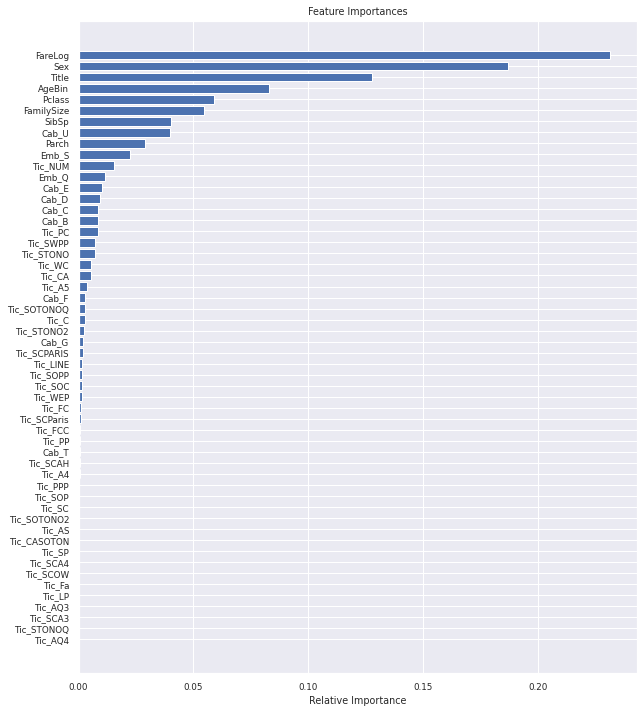

In [ ]:
# 랜덤 포레스트 모델의 피처 중요도
imp_features, imp_scores = plot_importance(rf_model, selected_features)

In [ ]:
# 상위 10개 피처만 선택
selected_features = imp_features[:10]      
y_train = data.loc[data['TrainSplit']=='Train', 'Survived']
X_train = data.loc[data['TrainSplit']=='Train', selected_features] 
X_test = data.loc[data['TrainSplit']=='Test', selected_features]
print("Train 데이터셋 크기: ", X_train.shape, y_train.shape)
print("Test 데이터셋 크기: ", X_test.shape)

Train 데이터셋 크기:  (891, 10) (891,)
Test 데이터셋 크기:  (418, 10)


In [ ]:
# 랜덤 포레스트
rf_model = RandomForestClassifier(random_state=2020)
auc_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')
print("개별 Fold의 AUC 점수: ", np.round(auc_scores, 4))
print("평균 AUC 점수: ", np.round(np.mean(auc_scores), 4))  
rf_model.fit(X_train, y_train)
y_test_pred = rf_model.predict(X_test)
submission['Survived'] = y_test_pred.astype(int)
submission_filepath = drive_path + 'baseline_rf_submission_002.csv'    
submission.to_csv(submission_filepath, index=False)

개별 Fold의 AUC 점수:  [0.8133 0.8637 0.8539]
평균 AUC 점수:  0.8436


In [ ]:
# XGBoost
from xgboost import XGBClassifier
xgb_model = XGBClassifier(max_depth=3, random_state=2020)
auc_scores = cross_val_score(xgb_model, X_train, y_train, cv=3, scoring='roc_auc')
print("개별 Fold의 AUC 점수: ", np.round(auc_scores, 4))
print("평균 AUC 점수: ", np.round(np.mean(auc_scores), 4))  
xgb_model.fit(X_train, y_train)
y_test_pred = xgb_model.predict(X_test)
submission['Survived'] = y_test_pred.astype(int)
submission_filepath = drive_path + 'baseline_xgb_submission_001.csv'    
submission.to_csv(submission_filepath, index=False)

개별 Fold의 AUC 점수:  [0.834  0.8867 0.9072]
평균 AUC 점수:  0.876


### 분류 확률값으로 제출파일 만들기

In [ ]:
# 확률값 예측
y_xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
y_rf_proba = rf_model.predict_proba(X_test)[:, 1]

# 앙상블 기법
y_proba = (y_xgb_proba + y_rf_proba) / 2
submission['Survived'] = y_proba
submission_filepath = drive_path + 'baseline_proba_submission_001.csv'    
submission.to_csv(submission_filepath, index=False)